In [1]:
%%time
import os
import numpy as np
os.chdir('../src/')
from util import clean_data as cd
from util import viz
import algos.basic as basic
import algos.similarity as sim
import pandas as pd
METADATA_PATH = '../data/Phenotypic_V1_0b_preprocessed1.csv'
PREFIX = '../data/rois_ez/'
POSTFIX = '_rois_ez.1D'

CPU times: user 740 ms, sys: 48 ms, total: 788 ms
Wall time: 2.23 s


In [2]:
%%time
md = cd.get_metadata(METADATA_PATH, ['FILE_ID', 'DX_GROUP'])

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 24.5 ms


In [3]:
%%time
good_md = cd.filter_file_names(md, PREFIX, POSTFIX)[::20]
f_names = np.array(map(lambda x: x['FILE_ID'], good_md))
dx_groups = np.array(map(lambda x: x['DX_GROUP'], good_md))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.8 ms


In [4]:
%%time
data = cd.get_data(f_names)

CPU times: user 580 ms, sys: 8 ms, total: 588 ms
Wall time: 582 ms


In [5]:
%%time
data = cd.run_function(basic.transpose, data)

Processed 0000 of 0045 brains.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 286 µs


In [6]:
%%time
data = cd.run_function(basic.mean_center, data)

Processed 0000 of 0045 brains.
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.61 ms


In [7]:
%%time
correl = cd.run_function(basic.correl, data)

Processed 0000 of 0045 brains.
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 55.4 ms


/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:2558: RuntimeWarning:

invalid value encountered in true_divide

/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning:

invalid value encountered in true_divide



In [8]:
viz.heatmap_channels(correl,
                     1,
                     title='Raw Data Heatmap',
                     xtitle='Timestep',
                     ytitle='ROI',
                     ztitle='4D Intensity (mean centered)')

In [9]:
%%time
dist = cd.run_function(sim.dtw, data)

Processed 0000 of 0045 brains.
CPU times: user 23.2 s, sys: 44 ms, total: 23.3 s
Wall time: 23.3 s


In [10]:
viz.heatmap_channels(dist,
                     1,
                     title='Raw Data Heatmap',
                     xtitle='Timestep',
                     ytitle='ROI',
                     ztitle='4D Intensity (mean centered)')

In [11]:
%%time
affinity = cd.run_function(basic.neg, dist)
labels = cd.run_function(sim.ap, affinity)
ordered = cd.run_function(basic.cluster_sort, zip(data, labels))
correl = cd.run_function(basic.correl, ordered)

Processed 0000 of 0045 brains.
Processed 0000 of 0045 brains.
Processed 0000 of 0045 brains.
Processed 0000 of 0045 brains.
CPU times: user 388 ms, sys: 8 ms, total: 396 ms
Wall time: 394 ms


In [12]:
viz.heatmap_channels(correl,
                     1,
                     title='Raw Data Heatmap',
                     xtitle='Timestep',
                     ytitle='ROI',
                     ztitle='4D Intensity (mean centered)')

In [13]:
%%time
sses = cd.run_function(basic.SSE, zip(data, labels))
ssses = [np.sum(s) for s in sses]

Processed 0000 of 0045 brains.
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 12.6 ms


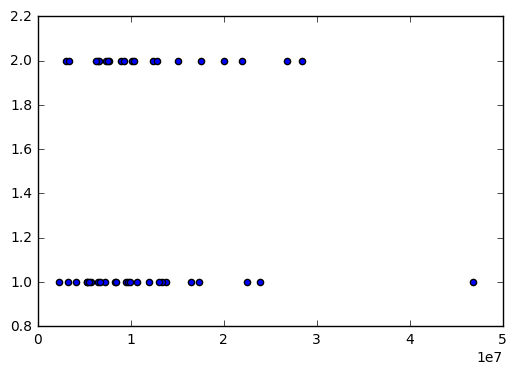

In [14]:
import matplotlib.pyplot as plt
plt.scatter(ssses, dx_groups)
plt.show()

Processed 0000 of 0045 brains.


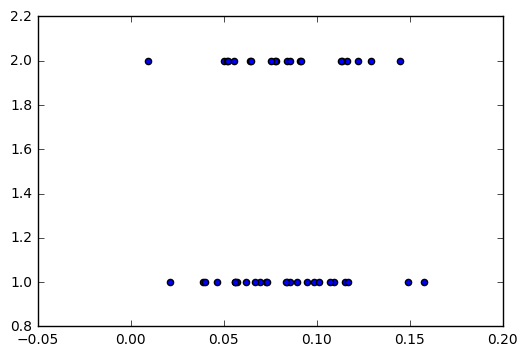

CPU times: user 344 ms, sys: 4 ms, total: 348 ms
Wall time: 342 ms


In [15]:
%%time
silhouette = cd.run_function(basic.silhouette, zip(dist, labels))
plt.scatter(silhouette, dx_groups)
plt.show()